In [127]:
!pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 k

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [22]:
import yolov5
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
import time
from torchvision.utils import draw_bounding_boxes
#from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, AutoImageProcessor, DefaultDataCollator
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
import tqdm
import os

In [ ]:
!pip freeze > requirements.txt.neuro

In [2]:
from pathlib import Path

In [3]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
%cd /content/drive/My Drive//Nuclear IT Hack

/content/drive/My Drive/Nuclear IT Hack


In [ ]:
!unzip dataset.zip

In [ ]:
!unzip dataset_test.zip

#Считывание исходного датасета

In [5]:
DATA_MODES = ["train", "val", "test"]
RESCALE_SIZE = 299
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
file_path_smoke = list(map(str, Path("./smokers").glob("*.jpg")))
file_path_non = list(map(str, Path("./people").glob("*.jpg")))
train_val_labels = [1] * len(file_path_smoke) + [0] * len(file_path_non)
file_path = file_path_smoke + file_path_non

In [7]:
test_files_smoke = list(map(str, Path("./dataset/smokers").glob("*.jpg")))
test_files_non = list(map(str, Path("./dataset/people").glob("*.jpg")))
add_files = test_files_smoke + test_files_non
add_labels = [1] * len(test_files_smoke) + [0] * len(test_files_non)

In [8]:
class SmokersDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, labels):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.labels = labels

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != "test":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.RandomHorizontalFlip(p=0.5),
            ])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = np.array(x / 255, dtype='float32')
            if list(x.shape) != [RESCALE_SIZE, RESCALE_SIZE, 3]:
                print(self.files[index], x.shape)
            x = transform(x)
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = np.array(x / 255, dtype='float32')

        label = self.labels[index]
        return x, label

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(file_path, train_val_labels, test_size=0.25, \
                                          stratify=train_val_labels)
train_files += add_files
train_labels += add_labels

# Обучение классификатора InceptionV3

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer, model_name):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        if model_name == "inception":
            outputs = model(inputs).logits
        else:
            outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.eval()
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()
        processed_size += inputs.size(0)
        # print(f"labels: {labels}")
        # print(f"preds: {preds}")
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [12]:
def train(train_files, val_files, model, epochs, batch_size, model_name):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm.tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, model_name)
            print("loss", train_loss)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.cuda.empty_cache()
    return history

In [13]:
def predict(model, test_loader):
    labels = []
    with torch.no_grad():
        logits = []

        for inputs, label in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            labels += label
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs, labels

In [69]:
my_inception_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [70]:
my_inception_v3.fc = nn.Linear(2048, 2)

In [71]:
for params in list(my_inception_v3.parameters())[:-5]:
    params.requires_grad = False

In [72]:
my_inception_v3.to(DEVICE)
1

1

In [73]:
val_dataset = SmokersDataset(val_files, mode='val', labels=val_labels)

train_dataset = SmokersDataset(train_files, mode='train', labels=train_labels)

In [74]:
history = train(train_dataset, val_dataset, model=my_inception_v3, epochs=7, batch_size=32, model_name="inception")

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.5939098733137217


epoch:  14%|█▍        | 1/7 [00:17<01:46, 17.80s/it]


Epoch 001 train_loss: 0.5939     val_loss 0.4615 train_acc 0.6754 val_acc 0.7913
loss 0.36409169094090243


epoch:  29%|██▊       | 2/7 [00:34<01:27, 17.41s/it]


Epoch 002 train_loss: 0.3641     val_loss 0.3926 train_acc 0.8616 val_acc 0.8522
loss 0.25598715037676484


epoch:  43%|████▎     | 3/7 [00:52<01:10, 17.60s/it]


Epoch 003 train_loss: 0.2560     val_loss 0.3900 train_acc 0.8926 val_acc 0.8435
loss 0.18535775550794487


epoch:  57%|█████▋    | 4/7 [01:10<00:52, 17.48s/it]


Epoch 004 train_loss: 0.1854     val_loss 0.4443 train_acc 0.9427 val_acc 0.8522
loss 0.15022406181173847


epoch:  71%|███████▏  | 5/7 [01:27<00:34, 17.37s/it]


Epoch 005 train_loss: 0.1502     val_loss 0.4367 train_acc 0.9594 val_acc 0.8522
loss 0.1002124924043767


epoch:  86%|████████▌ | 6/7 [01:49<00:19, 19.08s/it]


Epoch 006 train_loss: 0.1002     val_loss 0.4264 train_acc 0.9737 val_acc 0.8783
loss 0.062295246060253044


epoch: 100%|██████████| 7/7 [02:08<00:00, 18.42s/it]


Epoch 007 train_loss: 0.0623     val_loss 0.4371 train_acc 0.9905 val_acc 0.8609


In [75]:
loss, acc, val_loss, val_acc = zip(*history)

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
ax[0].plot(loss, label="train_loss")
ax[0].plot(val_loss, label="val_loss")
ax[0].legend(loc='best')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

ax[1].plot(acc, label="train_acc")
ax[1].plot(val_acc, label="val_acc")
ax[1].legend(loc='best')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [77]:
val_dataloader = DataLoader(val_dataset, batch_size=16)
probs_ims, true_labels = predict(my_inception_v3, val_dataloader)
y_pred = np.argmax(probs_ims,-1)

In [65]:
correct = np.sum(np.array(true_labels) == np.array(y_pred)) / len(y_pred)
print("Accuracy: ", correct)

Accuracy:  0.8695652173913043


In [66]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.8695652173913043


#AlexNet

In [90]:
my_alex = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 111MB/s] 


In [91]:
my_alex.classifier[4] = nn.Linear(4096, 2048)
my_alex.classifier[6] = nn.Linear(2048, 2)

In [92]:
for params in list(my_inception_v3.parameters())[:-10]:
    params.requires_grad = False

In [93]:
my_alex.to(DEVICE)
1

1

In [99]:
history = train(train_dataset, val_dataset, model=my_alex, epochs=10, batch_size=32, model_name = "alexnet")

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.7389818870502969


epoch:  10%|█         | 1/10 [00:20<03:06, 20.74s/it]


Epoch 001 train_loss: 1.7390     val_loss 0.6960 train_acc 0.6116 val_acc 0.4783
loss 0.6497915730960128


epoch:  20%|██        | 2/10 [00:36<02:24, 18.02s/it]


Epoch 002 train_loss: 0.6498     val_loss 0.8235 train_acc 0.6580 val_acc 0.6435
loss 0.693219728919043


epoch:  30%|███       | 3/10 [00:50<01:51, 15.87s/it]


Epoch 003 train_loss: 0.6932     val_loss 0.6825 train_acc 0.6029 val_acc 0.6696
loss 0.6949557585992675


epoch:  40%|████      | 4/10 [01:03<01:30, 15.03s/it]


Epoch 004 train_loss: 0.6950     val_loss 0.6856 train_acc 0.4609 val_acc 0.6000
loss 0.6500062645345495


epoch:  50%|█████     | 5/10 [01:17<01:12, 14.44s/it]


Epoch 005 train_loss: 0.6500     val_loss 0.6411 train_acc 0.6058 val_acc 0.6174
loss 0.62411038391832


epoch:  60%|██████    | 6/10 [01:30<00:56, 14.10s/it]


Epoch 006 train_loss: 0.6241     val_loss 0.6489 train_acc 0.6174 val_acc 0.6174
loss 0.637155254509138


epoch:  70%|███████   | 7/10 [01:44<00:42, 14.00s/it]


Epoch 007 train_loss: 0.6372     val_loss 0.6526 train_acc 0.6348 val_acc 0.6435
loss 0.6746855074080869


epoch:  80%|████████  | 8/10 [01:58<00:27, 13.83s/it]


Epoch 008 train_loss: 0.6747     val_loss 0.6661 train_acc 0.6087 val_acc 0.6522
loss 0.6378768855246945


epoch:  90%|█████████ | 9/10 [02:11<00:13, 13.76s/it]


Epoch 009 train_loss: 0.6379     val_loss 0.6700 train_acc 0.6232 val_acc 0.6174
loss 0.6450954610022945


epoch: 100%|██████████| 10/10 [02:25<00:00, 14.50s/it]


Epoch 010 train_loss: 0.6451     val_loss 0.6712 train_acc 0.6116 val_acc 0.6174


In [100]:
loss, acc, val_loss, val_acc = zip(*history)

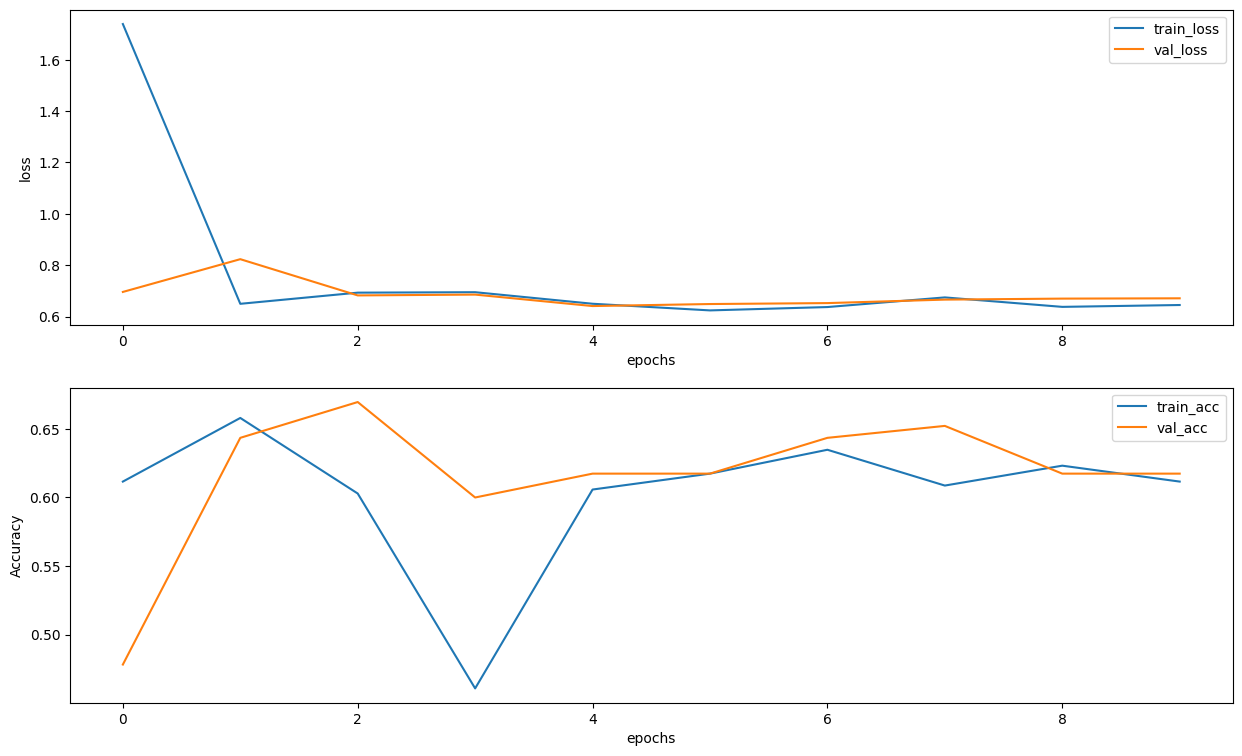

In [101]:
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
ax[0].plot(loss, label="train_loss")
ax[0].plot(val_loss, label="val_loss")
ax[0].legend(loc='best')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

ax[1].plot(acc, label="train_acc")
ax[1].plot(val_acc, label="val_acc")
ax[1].legend(loc='best')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [102]:
probs_ims, true_labels = predict(my_alex, val_dataloader)
y_pred = np.argmax(probs_ims,-1)

In [104]:
correct = np.sum(np.array(true_labels) == np.array(y_pred)) / len(y_pred)
correct

0.6173913043478261

In [105]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.6173913043478261


#Инференс

In [49]:
def save_weights(name, model):
    torch.save(model.state_dict(),f"{name}.pt")

def load_weights(name, model):
    model.load_state_dict(torch.load(f'{name}.pt'))

In [78]:
save_weights("inception_weights_1", my_inception_v3)

In [52]:
detector = yolov5.load('yolov5s.pt')

detector.conf = 0.25
detector.iou = 0.45
detector.agnostic = False
detector.multi_label = False
detector.max_det = 30
detector.classes = 0

classificator  = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
classificator.fc = nn.Linear(2048, 2)
load_weights("inception_weights", classificator)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        max_prob = np.max(probs)
        y_pred = np.argmax(probs,-1)
    return y_pred, max_prob

In [53]:
def analize(example_image):
    prediction = []
    probability = []
    bboxes = []
    result = detector(example_image)
    result = result.crop(save=False)
    n_all_people = len(result)
    for imgs in result:
        if float(imgs['conf'].cpu().numpy()) >= 0.85:
            bbox = imgs['box']
            bbox = [float(val.cpu().numpy()) for val in bbox]
            example_image1 = example_image.crop(bbox)
            example_image1 = example_image.resize((RESCALE_SIZE, RESCALE_SIZE))
            example_image1 = np.array(np.array(example_image1) / 255, dtype='float32')
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
            example_image1 = transform(example_image)

            pred, prop = predict_one_sample(classificator.to(DEVICE), example_image1.unsqueeze(0), device=DEVICE)
            if pred[0] == 1:
                bboxes.append(bbox)
                prediction.append(pred[0])
                probability.append(prop)

    draw = ImageDraw.Draw(example_image)
    for bbox in bboxes:
        draw.rectangle(tuple(bbox), outline="red", width=3)

    return example_image, n_all_people, len(prediction)